In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cuprite_data=scipy.io.loadmat('/content/drive/MyDrive/Cuprite_f970619t01p02_r02_sc03.a.rfl.mat')

In [3]:
info=scipy.io.whosmat('/content/drive/MyDrive/Cuprite_f970619t01p02_r02_sc03.a.rfl.mat')
print(info)

[('X', (512, 614, 224), 'int16')]


In [4]:
cuprite_data=cuprite_data["X"]

In [5]:
print(cuprite_data.shape)

(512, 614, 224)


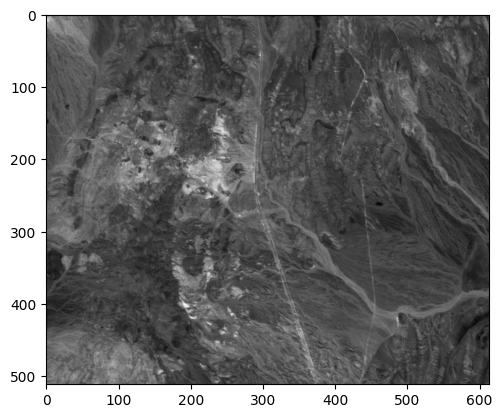

In [6]:
# selecting the bands for red, green and blue channels
red_band=cuprite_data[:,:,2]
green_band=cuprite_data[:,:,12]
blue_band=cuprite_data[:,:,22]

gray_image=(red_band+green_band+blue_band)/3

plt.imshow(gray_image,cmap='gray')


In [7]:
import math
from skimage import io, color
from skimage.transform import resize
from sklearn.preprocessing import normalize
import numpy as np

class SuperPixels:
    def __init__(self, h, w, spectrum):
        self.h = h
        self.w = w
        self.spectrum = spectrum

    def update(self, h, w, spectrum):
        self.h = h
        self.w = w
        self.spectrum = spectrum

def make_superPixel(h, w, img):
    return SuperPixels(h, w, img[h, w])

def initial_cluster_center(S, img, img_h, img_w, clusters):
    h = S // 2
    w = S // 2
    while h < img_h:
        while w < img_w:
            clusters.append(make_superPixel(h, w, img))
            w += S
        w = S // 2
        h += S
    return clusters

def calc_gradient(h, w, img, img_w, img_h):
    if w + 1 >= img_w:
        w = img_w - 2
    if h + 1 >= img_h:
        h = img_h - 2
    grad = np.sum(np.abs(img[h + 1, w + 1] - img[h, w]))
    return grad

def reassign_cluster_center_acc_to_grad(clusters, img, img_w, img_h):
    for c in clusters:
        cluster_gradient = calc_gradient(c.h, c.w, img, img_w, img_h)
        for dh in range(-1, 2):
            for dw in range(-1, 2):
                H = c.h + dh
                W = c.w + dw
                new_gradient = calc_gradient(H, W, img, img_w, img_h)
                if new_gradient < cluster_gradient:
                    c.update(H, W, img[H, W])
                    cluster_gradient = new_gradient

def calculate_distance(pixel1, pixel2, h1, h2, w1, w2, S):
    spectral_distance = np.linalg.norm(pixel1 - pixel2)
    spatial_distance = math.sqrt((h2 - h1)**2 + (w2 - w1)**2)
    return spectral_distance + (spatial_distance / S)

def assign_pixels_to_clusters(img, clusters, S):
    img_h, img_w, _ = img.shape
    labels = np.full((img_h, img_w), -1)
    distances = np.full((img_h, img_w), np.inf)

    for idx, c in enumerate(clusters):
        for dh in range(-S, S):
            for dw in range(-S, S):
                h = c.h + dh
                w = c.w + dw

                if h >= 0 and h < img_h and w >= 0 and w < img_w:
                    D = calculate_distance(c.spectrum, img[h, w], c.h, h, c.w, w, S)
                    if D < distances[h, w]:
                        distances[h, w] = D
                        labels[h, w] = idx

    return labels

def update_cluster_centers(img, clusters, labels):
    new_clusters = []
    for i in range(len(clusters)):
        indices = np.where(labels == i)
        if len(indices[0]) == 0:
            new_clusters.append(clusters[i])
        else:
            new_h = int(np.mean(indices[0]))
            new_w = int(np.mean(indices[1]))
            new_spectrum = np.mean(img[indices], axis=0)
            new_clusters.append(SuperPixels(new_h, new_w, new_spectrum))
    return new_clusters

def slic(img, num_segments, max_iter=10):
    img_h, img_w, _ = img.shape
    S = int(math.sqrt((img_h * img_w) / num_segments))
    clusters = []
    clusters = initial_cluster_center(S, img, img_h, img_w, clusters)
    reassign_cluster_center_acc_to_grad(clusters, img, img_w, img_h)

    for _ in range(max_iter):
        labels = assign_pixels_to_clusters(img, clusters, S)
        clusters = update_cluster_centers(img, clusters, labels)

    return labels, clusters

# Load a hyperspectral image
# Assuming hyperspectral image is a numpy array of shape (height, width, bands)
# hyperspectral_image = np.load('hyperspectral_image.npy')  # Replace with actual file path

num_segments = 100  # Number of superpixels
labels, clusters = slic(cuprite_data, num_segments)

# Display or further process the result
print(labels)


[[ 0  0  0 ...  9 10 10]
 [ 0  0  0 ... 10  9  9]
 [ 0  0  0 ... 10 10 10]
 ...
 [88 88 88 ... 87 98 98]
 [88 88 88 ... 98 87 87]
 [88 88 88 ... 87 87 98]]


<ipython-input-9-49ead62b30eb>:8: UserWarning: The following kwargs were not used by contour: 'contours'
  plt.contour(labels, contours=np.arange(0, num_segments), colors='r')


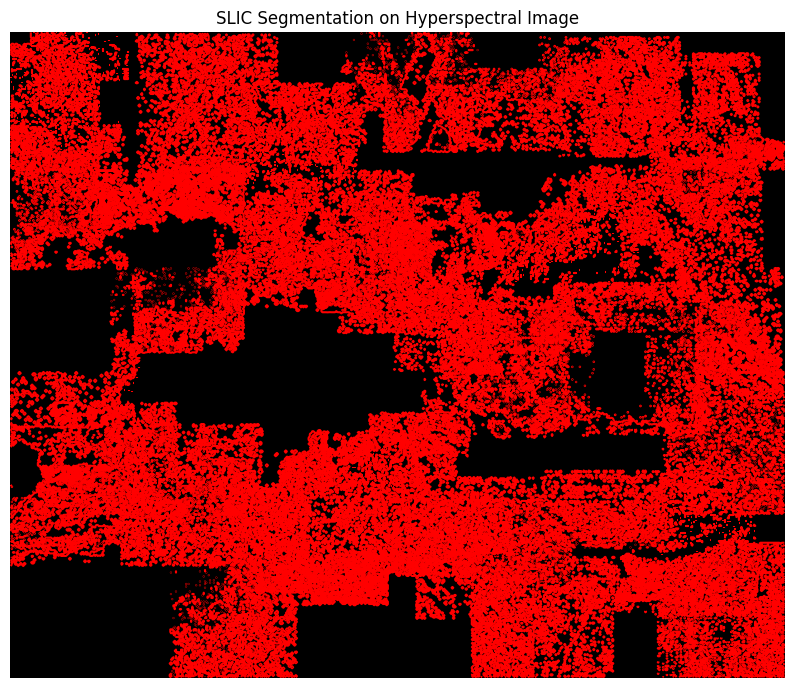

In [9]:
# Plot the results
def plot_segmentation_results(img, labels):
    # Use the first band for visualization, or combine bands as needed
    visualization_img = img[:, :, 0]

    plt.figure(figsize=(10, 10))
    plt.imshow(visualization_img, cmap='gray')
    plt.contour(labels, contours=np.arange(0, num_segments), colors='r')
    plt.title('SLIC Segmentation on Hyperspectral Image')
    plt.axis('off')
    plt.show()

plot_segmentation_results(cuprite_data, labels)

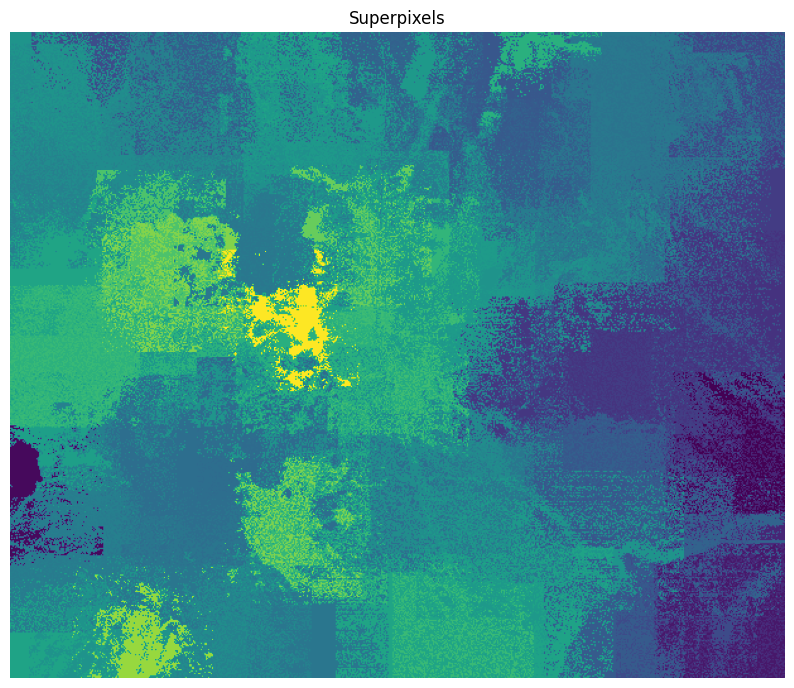

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image(image, title):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def superpixel_plot_hyperspectral(im, seg, title="Superpixels"):
    """
        Given a hyperspectral image (nXmXbands) and pixelwise class mat (nXm),
        1. Consider each class as a superpixel
        2. Calculate mean superpixel value for each class across all bands
        3. Replace the spectral value of each pixel in a class with the mean value

        Inputs:
        im: Input hyperspectral image
        seg: Segmentation map
        title: Title of the plot

        Output: None
        Creates a plot
    """
    clust = np.unique(seg)
    num_bands = im.shape[2]

    mapper_dict = {i: im[seg == i].mean(axis=0) for i in clust}

    seg_img = np.zeros((seg.shape[0], seg.shape[1], num_bands))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]

    # For visualization, let's take the mean across bands
    vis_img = seg_img.mean(axis=2)

    plot_image(vis_img, title)

# Load a hyperspectral image
hyperspectral_image = cuprite_data # Replace with actual file path

# Assuming labels are obtained from the SLIC algorithm as shown previously
num_segments = 100  # Number of superpixels
# labels, clusters = slic(hyperspectral_image, num_segments)

# Plot the pixelwise class plot for the hyperspectral image
superpixel_plot_hyperspectral(hyperspectral_image, labels)





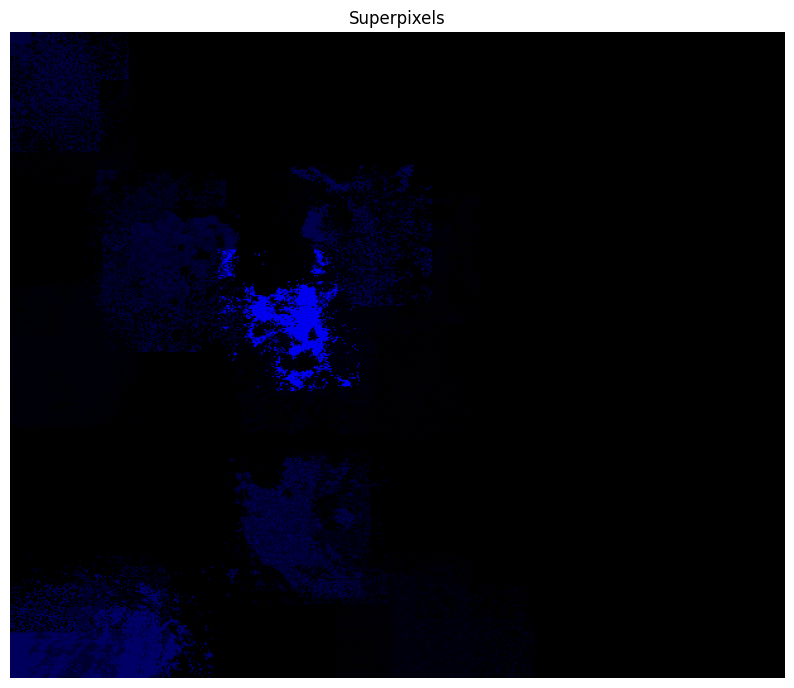

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image(image, title):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def superpixel_plot_hyperspectral(im, seg, title="Superpixels", bands=[2, 12, 22]):
    """
        Given a hyperspectral image (nXmXbands) and pixelwise class mat (nXm),
        1. Consider each class as a superpixel
        2. Calculate mean superpixel value for each class across the selected bands
        3. Replace the spectral value of each pixel in a class with the mean value

        Inputs:
        im: Input hyperspectral image
        seg: Segmentation map
        title: Title of the plot
        bands: List of three bands to be used for RGB visualization

        Output: None
        Creates a plot
    """
    clust = np.unique(seg)

    mapper_dict = {i: im[seg == i][:, bands].mean(axis=0) /255. for i in clust}

    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]

    plot_image(seg_img, title)

# Load a hyperspectral image
# hyperspectral_image = np.load('/mnt/data/hyperspectral_image.npy')  # Replace with actual file path

# Assuming labels are obtained from the SLIC algorithm as shown previously
num_segments = 100  # Number of superpixels
# labels, clusters = slic(hyperspectral_image, num_segments)

# Plot the pixelwise class plot for the hyperspectral image
# Here we consider bands [0, 1, 2] for RGB visualization
superpixel_plot_hyperspectral(hyperspectral_image, labels, bands=[0, 1, 2])


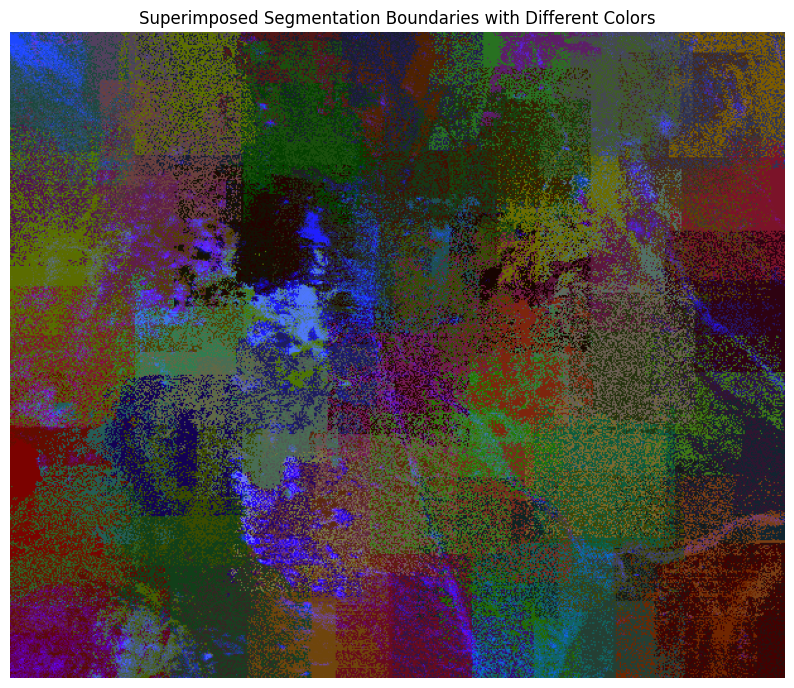

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import matplotlib.colors as mcolors
import random

def plot_image(image, title):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()


def create_random_colormap(n_classes):
    """
    Create a color map with n_classes unique colors.

    Inputs:
    n_classes: Number of unique classes

    Output:
    colormap: A list of colors
    """
    colormap = []
    for _ in range(n_classes):
        colormap.append((random.random(), random.random(), random.random()))
    return colormap

def superimpose_clusters_on_image(original_image, labels, bands=[0, 1, 2]):
    """
    Superimpose the segmentation boundaries on the original image with different colors for each class.

    Inputs:
    original_image: Hyperspectral image
    labels: Segmentation labels from SLIC
    bands: List of three bands to be used for RGB visualization

    Output: None
    Creates a plot
    """
    # Create RGB image from selected bands
    rgb_image = original_image[:, :, bands] / 255.0

    # Get unique classes and create a color map
    unique_labels = np.unique(labels)
    colormap = create_random_colormap(len(unique_labels))

    # Initialize an empty image for the segmentation overlay
    seg_overlay = np.zeros_like(rgb_image)

    # Assign colors to each superpixel class
    for i, label in enumerate(unique_labels):
        seg_overlay[labels == label] = colormap[i]

    # Combine the RGB image and segmentation overlay
    combined_image = (rgb_image * 0.5 + seg_overlay * 0.5).clip(0, 1)

    # Plot the combined image
    plot_image(combined_image, "Superimposed Segmentation Boundaries with Different Colors")

# Load a hyperspectral image
# hyperspectral_image = np.load('/mnt/data/hyperspectral_image.npy')  # Replace with actual file path

# Assuming labels are obtained from the SLIC algorithm as shown previously
num_segments = 100  # Number of superpixels
# labels, clusters = slic(hyperspectral_image, num_segments)

# Superimpose clusters on the original image using selected bands
superimpose_clusters_on_image(hyperspectral_image, labels, bands=[0, 1, 2])
